<a href="https://colab.research.google.com/github/jrottari/Mow-Times/blob/main/Mowing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Packages and Setting Up Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.stats
import os
from google.colab import drive
import pandas as pan
import sklearn
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
rng = np.random.default_rng()

#to run this code, upload the proper files to your google drive and
# mount your drive as is done here
drive.mount('/content/drive')
data = np.loadtxt("/content/drive/MyDrive/mow.regression.csv",
                delimiter=",", dtype=str)[1:,]
#this is the data after recatgeorzing lawns as dry/wet and flat/hilly
#data = np.loadtxt("/content/drive/MyDrive/mow.regression.recoded.csv",
#                delimiter=",", dtype=str)[1:,]

data_s = pan.read_csv("/content/drive/MyDrive/mow.summary.csv",
                sep=",")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#making the data numerical and trying different transformations
#mow = np.column_stack(( data[:,0].astype(float), data[:,1].astype(float), data[:,2].astype(float),
#                       data[:,3].astype(float)))
mow = np.column_stack(( data[:,0].astype(float), data[:,1].astype(float), data[:,2].astype(float),
                       data[:,3].astype(float)))


In [ ]:
#mow = mow[mow[:,1] < 20000,:]
#print(data_s)

In [ ]:
#for plots using the full data
y = mow[:,0]
#y = np.log(mow[:,0])
x = mow[:,1]
xs = x

In [ ]:
#fitting a model with the dummy variables
#design matrix using the full data
X_d = np.column_stack(([np.ones(len(mow[:,0])), xs,  mow[:,2:]]))

#this is the design matrix for models based on the summarized data
#X_d =  np.column_stack((np.ones(len(y)), xs, np.array(data_s["Dry/Wet"]),
 #                     np.array(data_s["Flat/Hilly"])))

X_s = X_d[:,0:2]


In [ ]:
#for plots using the summarized data
#y = np.array(data_s["Mean"])
y = np.array(data_s["3rd Qu."])
x = np.array(data_s["Sq. Ft."])
xs = x

# Initial Plots

Text(0, 0.5, 'Service Time (Minutes)')

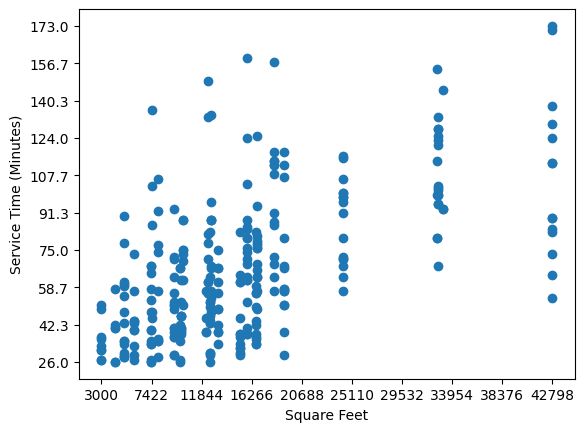

In [ ]:
#for making plots of the data
#change y and xs above for different plots and change the axis labels as necessary
plt.scatter(xs, y)
plt.xticks(np.linspace(np.min(xs), np.max(xs), 10))
plt.yticks(np.linspace(np.min(y), np.max(y), 10))
plt.xlabel("Square Feet")
plt.ylabel("Service Time (Minutes)")

# Regression Without Dummy Variables

In [ ]:
#this fits a polynomial without the dummy variables
p = 2
def polynomial_mle(xs, ys, p, W = np.identity(len(xs))):
  # p is the number of regression coefficients,
  # or 1 + the degree of the fitted polynomial
  # p means different things for the 1 + x + x^{1/2} + ... case

  #this is for analyzing polynomials of the form 1 + x + x^{1/2} + x^{1/3}...
  #X = np.column_stack((np.ones(len(xs)), np.array([xs**(1/(i+1)) for i in range(p)]).T))
  #this is for a polynomial of the form 1 + x + x^2...
  X = np.array([xs**i for i in range(p)]).T
  return np.linalg.solve(X.T@W@X, X.T@W@ys)
beta_p = polynomial_mle(xs, y, p)
#this is for analyzing polynomials without dummy variables when y is just service time
X_p =  np.array([xs**i for i in range(p)]).T
#this is for analyzing polynomials of the form 1 + x_1 + x^{-2} + x^{3}...
# without dummy variables
#X_p =  np.column_stack((np.ones(len(xs)), np.array([xs**(1/(i+1)) for i in range(p)]).T))


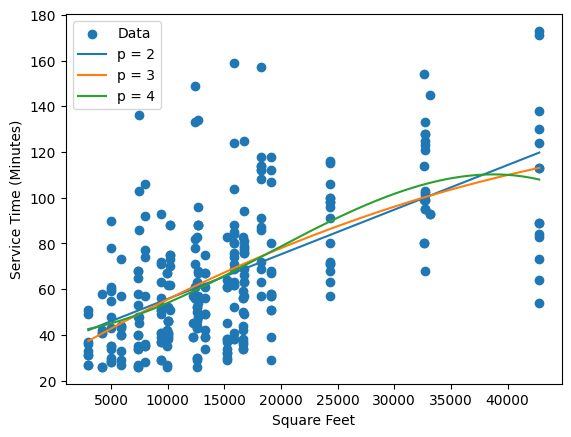

In [ ]:
#plotting different fits without dummy variables not included
plot_xs = np.linspace(np.min(xs), np.max(xs), len(xs))
def plot_polynomial(coefs, xs, tag = ""):
  #for plotting 1 + x + x^2
  p = len(coefs)
  #for plottig 1 + x + x^{1/2}+ ...
  #p = len(coefs)-1
  #for plotting 1 + x + x^2 + ...
  ys = np.array([xs**i for i in range(p)]).T@coefs
  #for plotting 1 + x + x^{1/2} + x^{1/3} + ...
  #ys = np.column_stack((np.ones(len(xs)), np.array([xs**(1/(i+1)) for i in range(p)]).T))@coefs
  plt.plot(xs, ys, label = f"p = {len(coefs)}"+tag)
  return

plt.scatter(xs, y, label = "Data")
plt.xlabel("Square Feet")
plt.ylabel("Service Time (Minutes)");

plot_polynomial(polynomial_mle(xs, y, 2), plot_xs)
plot_polynomial(polynomial_mle(xs, y, 3), plot_xs)
plot_polynomial(polynomial_mle(xs, y, 4), plot_xs)

plt.legend()

# Regression With Dummy Variables

In [ ]:
#trying a polynomial fit with dummy variables included
#deg of polynomial = p-1
# can change i to -i for looking at square roots
p = 2
def polynomial_mled(xs, ys, p):
  # p is 1 + the degree of the fitted polynomial
  X = np.column_stack((np.array([xs**i for i in range(p)]).T, X_d[:,2:]))
  #this is for analyzing polynomials of the form 1 + x + x^{1/2} + x^{1/3}...
  #X = np.column_stack((np.ones(len(xs)), np.array([xs**(1/(i+1)) for i in range(p)]).T, X_d[:,2:]))
  return np.linalg.solve(X.T@X, X.T@ys)
beta_p = polynomial_mled(xs, y, p)
#this is for analyzing polynomials with variables when y and can be changed
# if you wantto use the summarized data vs the unsummarized data
X_p = np.column_stack((np.array([xs**i for i in range(p)]).T, X_d[:,2:]))
#for polynomials of the form 1 + x + x^{1/2} + ...
#X_p = np.column_stack((np.ones(len(xs)), np.array([xs**(1/(i+1)) for i in range(p)]).T, X_d[:,2:]))


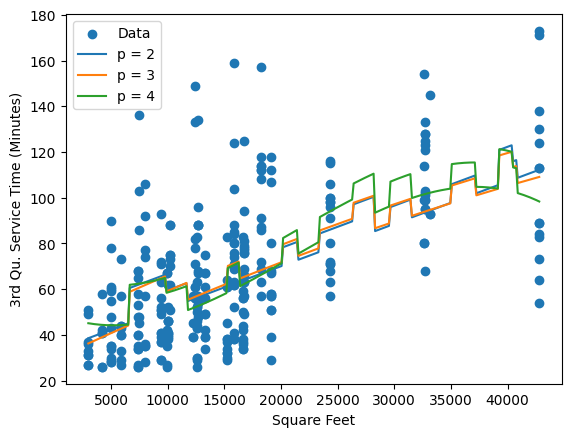

In [ ]:
#plotting different fits with dummy variables included
plot_xs = np.linspace(np.min(xs), np.max(xs), len(xs))
def plot_polynomiald(coefs, xs, tag = ""):
  #for plotting 1 + x + x^2 + ...
  p = len(coefs)-2
  #for plottig 1 + x + x^{1/2}+ ...
  #p = len(coefs)-3
  #for polynomials of the form 1 + x^2 + x^3 + ...
  ys = np.column_stack((np.array([xs**i for i in range(p)]).T, X_d[:,2:]))@coefs
  #for polynomials of the form 1 + x + x^{1/2} + x^{1/3}...
  #ys = np.column_stack((np.ones(len(xs)), np.array([xs**(1/(i+1)) for i in range(p)]).T, X_d[:,2:]))@coefs
  plt.plot(xs, ys, label = f"p = {len(coefs)-2}"+tag)
  return

plt.scatter(xs, y, label = "Data")
plt.xlabel("Square Feet")
plt.ylabel("3rd Qu. Service Time (Minutes)");

plot_polynomiald(polynomial_mled(xs, y, 2), plot_xs)
plot_polynomiald(polynomial_mled(xs, y, 3), plot_xs)
plot_polynomiald(polynomial_mled(xs, y, 4), plot_xs)

plt.legend()

# Weighted Least Squares

In [ ]:
#to make a weighted model for the third quantile we need an estimate of the
#variance of each of the 3rd quantiles, which we'll use bootstrapping for
rng = np.random.default_rng()
import random
sizes = np.array(data_s['Sq. Ft.'])

bootstrap_dat = np.column_stack((mow[:,0],mow[:,1]))
data_l = []
for i in range(len(sizes)):
  data_l.append(bootstrap_dat[bootstrap_dat[:,1] == sizes[i],0])

In [ ]:
#getting estimates of the variance of the third quartile
#estimator using bootstrapping
def bootstrap(list = data_l, numsamps = 1000):
  np.random.seed(5)
  tmp = []
  for i in range(len(data_l)):
    tmp_n = len(data_l[i])
    tmp_in = []
    for k in range(numsamps):
      samp_ind = rng.choice(tmp_n, tmp_n, replace = True)
      tmp_dat = data_l[i][samp_ind]
      tmp_in.append(np.quantile(tmp_dat, .75))
    tmp.append(np.var(tmp_in))
  return tmp
q3_vars = bootstrap(numsamps = 10000)

In [ ]:
#weights for weighted reqression of the third quartile
q3_weights = np.diag(1/np.array(q3_vars))

In [ ]:
#for weighted least squares using the full data

tmp = []
for i in range(len(np.array(data_s["Sq. Ft."]))):
  tmp.append((np.array(data_s["sd"])[i]*np.ones(np.array(data_s["n"])[i]))**2)

In [ ]:
#creating the weight matrix using estimates of variance
#for the whole data set
W_tmp = np.concatenate((tmp), axis = None)
Weights = LA.inv(np.diag(W_tmp))

#creating the weight matrix for the aggregated data if modeling E[y|x]
#Weights = np.diag(1/(np.array(data_s["sd"])**2/np.array(data_s["n"])))
#Weights = np.diag(1/np.array(data_s["n"]))


In [ ]:
#getting a fit for residual checking
#change xs and y depending on what you're modeling and what type of polynomial
# you try
p=2
beta_p = polynomial_mle(xs, y, p, W=q3_weights )
#X_p =  np.array([xs**i for i in range(p)]).T
X_p =  np.column_stack((np.ones(len(xs)), np.array([xs**(1/(i+1)) for i in range(p)]).T))

In [ ]:
#plotting different fits without dummy variables not included
plot_xs = np.linspace(np.min(xs), np.max(xs), len(xs))
plt.scatter(xs, y, label = "Data")
plt.xlabel("Square Feet")
plt.ylabel("Service Time (Minutes)");

plot_polynomial(polynomial_mle(xs, y, 2, W=q3_weights ), plot_xs)
plot_polynomial(polynomial_mle(xs, y, 3, W=q3_weights ), plot_xs)
plot_polynomial(polynomial_mle(xs, y, 4, W=q3_weights ), plot_xs)

plt.legend()

# Checking R^2 and Residuals

In [ ]:
#this code depends on the code above
#change the data in the first section and change the model using
# one of the three sections above
residuals = y - X_p@beta_p
#looking at R^2 and adjusted R^2
R_2 = 1 -  np.sum(residuals**2)/np.sum((y - np.mean(y))**2)
adjusted_R_2 = 1 - (1- R_2)*(len(y) - 1)/(len(y) - len(beta_p) -1 )
print(R_2)
print(adjusted_R_2)

0.39398502338861163
0.38562619612500626


Text(0.5, 0, 'fitted value')

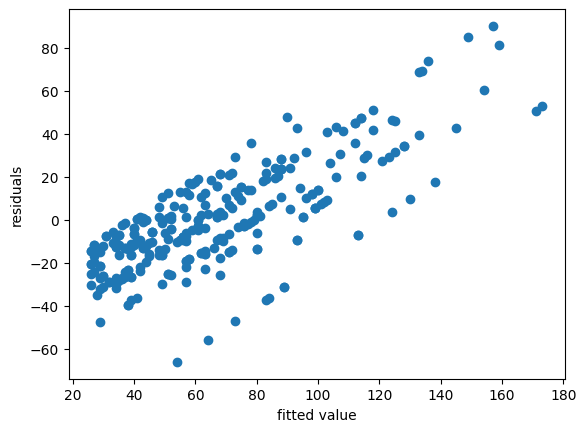

In [ ]:
#checking homoscedasticity
plt.scatter(y, residuals)
plt.ylabel("residuals")
plt.xlabel("fitted value")

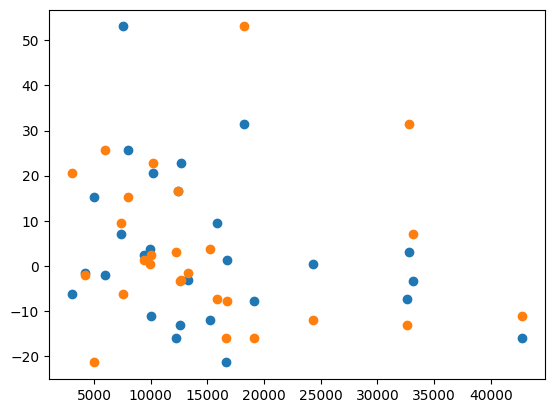

In [ ]:
#checking homescedasticity
plt.scatter(xs, residuals)
plt.scatter(xs, residuals[rng.permutation(len(xs))])

(array([ 2.,  9., 45., 95., 67., 39., 21., 10.,  4.,  3.]),
 array([-66.24656621, -50.59615768, -34.94574915, -19.29534062,
         -3.64493209,  12.00547644,  27.65588497,  43.3062935 ,
         58.95670203,  74.60711056,  90.25751909]),
 <BarContainer object of 10 artists>)

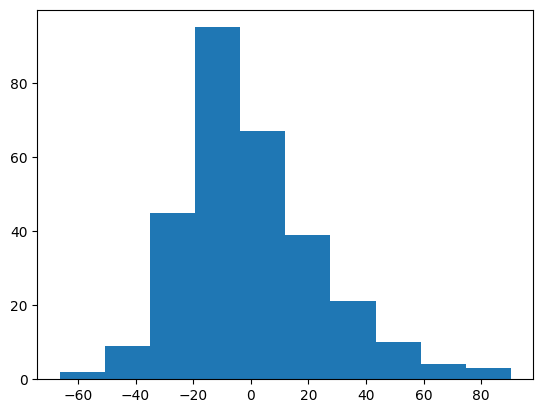

In [ ]:
#checking normality
plt.hist(residuals)

In [ ]:
#checking normality
print(scipy.stats.shapiro(residuals), "\n")

print(scipy.stats.anderson(residuals), "\n")


standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
print(scipy.stats.ks_1samp(residuals, scipy.stats.norm.cdf), "\n")

print(scipy.stats.ks_1samp(standardized_residuals, scipy.stats.norm.cdf), "\n")

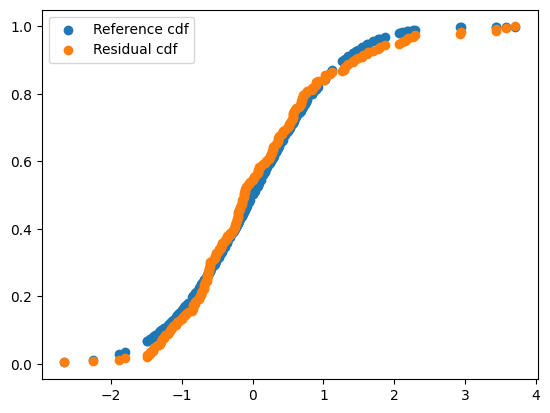

In [ ]:
#checking normality
plt.scatter(np.sort(np.unique(standardized_residuals)),
         scipy.stats.norm().cdf(np.sort(np.unique(standardized_residuals))),
         label = "Reference cdf"
         )
plt.scatter(np.sort(np.unique(standardized_residuals)),
         scipy.stats.ecdf(np.unique(standardized_residuals)).cdf.probabilities,
         label = "Residual cdf"
         )
plt.legend()

# Cross-Validation

In [ ]:
#cross validation
#need to modify code to do cross-validation with the weighted model
model = LinearRegression()
loo = cross_validate(model, X_p, y, cv = len(y), scoring = 'neg_mean_squared_error')
cv5 = cross_validate(model, X_p, y, cv = 5, scoring = 'neg_mean_squared_error')
cv10 = cross_validate(model, X_p, y, cv = 10, scoring = 'neg_mean_squared_error')
print(np.mean(-1*loo.get('test_score')))
print(np.mean(-1*cv5.get('test_score')))
print(np.mean(-1*cv10.get('test_score')))

# Inference

In [ ]:
from scipy.stats import t,f
# getting the point estimate for the regression coefficients
#we know refer to the model with E[y] with x_1 and x_2 as m1, with x_1, x2, x_{p-1}, x_p
# as m2, and m3 and m4 and m5 for the models with 3rd qu y
#data
y1 = np.array(data_s["Mean"])
y3 = np.array(data_s["3rd Qu."])
x = np.array(data_s["Sq. Ft."])
xs = x
#includes dummy variables
X_d =  np.column_stack((np.ones(len(y1)), xs, np.array(data_s["Dry/Wet"]),
                       np.array(data_s["Flat/Hilly"])))
#no dummy variables
X_s = X_d[:,0:2]

beta1 = LA.solve(X_s.T @ X_s, X_s.T @ y1)
#beta2 = LA.solve(X_d.T @ X_d, X_d.T @ y1)
beta3 = LA.solve(X_s.T @ X_s, X_s.T @ y3)
#beta4 = LA.solve(X_d.T @ X_d, X_d.T @ y3)
beta5 = polynomial_mle(xs, y3, 2, W = q3_weights)
#printing the maximum likelihood estimate
#print(beta_hat)


In [ ]:
# creating confidence intervals
#computing s^2
linear_s_squared1 = (np.linalg.norm(y1 - X_s@beta1)**2) / (len(y1) - len(beta1))
#linear_s_squared2 = (np.linalg.norm(y1 - X_d@beta2)**2) / (len(y1) - len(beta2))
linear_s_squared3 = (np.linalg.norm(y3 - X_s@beta3)**2) / (len(y3) - len(beta3))
#linear_s_squared4 = (np.linalg.norm(y3 - X_d@beta4)**2) / (len(y3) - len(beta4))
#for the weighted q3 model
linear_s_squared5=  (y3 - X_s@beta5).T@q3_weights@(y3 - X_s@beta5)/(len(y3) - len(beta5))
#this computes the scaling factor on each entry in beta_hat for the t-interval
# for a specific entry in beta_hat and np.diagonol is what picks off the specific
# scaling coefficient for a particular entry of beta_hat
linear_error_scales1 = np.sqrt(linear_s_squared1*
                              np.diagonal(np.linalg.inv(X_s.T@X_s))
                              )
#linear_error_scales2 = np.sqrt(linear_s_squared2*
#                              np.diagonal(np.linalg.inv(X_d.T@X_d))
#                              )
linear_error_scales3 = np.sqrt(linear_s_squared3*
                              np.diagonal(np.linalg.inv(X_s.T@X_s))
                              )
#linear_error_scales4 = np.sqrt(linear_s_squared4*
#                              np.diagonal(np.linalg.inv(X_d.T@X_d))
#                              )
linear_error_scales5 = np.sqrt(linear_s_squared5*
                               np.diagonal(LA.inv(X_s.T@q3_weights@X_s))
                               )
alpha = 0.05
linear_95_conf_width1 = t.ppf(1 - alpha/2, len(y1) - len(beta1))*linear_error_scales1
linear_joint_95_width1 = np.sqrt(len(beta1))*f.ppf(1-alpha, len(beta1), len(y1) - len(beta1))*linear_error_scales1
#linear_95_conf_width2 = t.ppf(1 - alpha/2, len(y1) - len(beta2))*linear_error_scales2
#linear_joint_95_width2 = np.sqrt(len(beta2))*f.ppf(1-alpha, len(beta2), len(y1) - len(beta2))*linear_error_scales2
linear_95_conf_width3 = t.ppf(1 - alpha/2, len(y3) - len(beta3))*linear_error_scales3
linear_joint_95_width3 = np.sqrt(len(beta3))*f.ppf(1-alpha, len(beta3), len(y3) - len(beta3))*linear_error_scales3
#linear_95_conf_width4 = t.ppf(1 - alpha/2, len(y3) - len(beta4))*linear_error_scales4
#linear_joint_95_width4 = np.sqrt(len(beta4))*f.ppf(1-alpha, len(beta4), len(y3) - len(beta4))*linear_error_scales4
linear_95_conf_width5 = t.ppf(1 - alpha/2, len(y3) - len(beta5))*linear_error_scales5
#printing the confidence intervals
# array with the confidence intervals
beta1CIs = np.column_stack((beta1 - linear_95_conf_width1,beta1 + linear_95_conf_width1) )
#beta2CIs = np.column_stack((beta2 - linear_95_conf_width2,beta2 + linear_95_conf_width2) )
beta3CIs = np.column_stack((beta3 - linear_95_conf_width3,beta3 + linear_95_conf_width3) )
beta5CIs = np.column_stack((beta5 - linear_95_conf_width5,beta5 + linear_95_conf_width5) )
#beta4CIs = np.column_stack((beta4 - linear_95_conf_width4,beta4 + linear_95_conf_width4) )
simbeta1CIs = np.column_stack((beta1 - linear_joint_95_width1,beta1 + linear_joint_95_width1) )
#simbeta2CIs = np.column_stack((beta2 - linear_joint_95_width2,beta2 + linear_joint_95_width2) )
simbeta3CIs = np.column_stack((beta3 - linear_joint_95_width3,beta3 + linear_joint_95_width3) )
#simbeta4CIs = np.column_stack((beta4 - linear_joint_95_width4,beta4 + linear_joint_95_width4) )
#print(beta1CIs)
#print(beta2CIs)
#print(beta3CIs)
#print(beta4CIs)
#print(simbeta1CIs)
#print(simbeta2CIs)
#print(simbeta3CIs)
#print(simbeta4CIs)


In [ ]:
#plotting the regression estimates with their confidence intervals along with a line
# showing the true values of beta
#axis = np.linspace(1,4,4)
#plt.scatter( axis, beta4, s =5)
#plt.errorbar(axis,beta4,
#             yerr = linear_95_conf_width4, fmt="none", alpha = .5, c = "g")
#plt.scatter( axis, beta4, s =3)
#plt.errorbar(axis,beta4,
#             yerr = linear_joint_95_width4, fmt="none", alpha = .5, c = "r")
plt.xlabel("Parameter")
plt.ylabel("Value (Min/Square Feet)")



# Model 1 Plots

In [ ]:
#setting the square root values
V = np.column_stack((np.ones(100), np.linspace(np.min(xs), np.max(xs), 100)))
Ey = V@beta1
#creating confidence bands for model 1
PL_linear_error_scales1 = np.sqrt(linear_s_squared1*np.diagonal(V@np.linalg.inv(X_s.T@X_s)@(V.T)))
PL_linear_95_conf_width = t.ppf(1 - alpha/2, len(y1) - len(beta1))*PL_linear_error_scales1
PL_joint_Linear_95_conf_width = np.sqrt(len(beta1))*f.ppf(1-alpha, len(beta1), len(y1) - len(beta1))*PL_linear_error_scales1
#creating confidence bands for model 3
q3y = V@beta3
PL_linear_error_scales3 = np.sqrt(linear_s_squared3*np.diagonal(V@np.linalg.inv(X_s.T@X_s)@(V.T)))
PL_linear_95_conf_width3 = t.ppf(1 - alpha/2, len(y3) - len(beta3))*PL_linear_error_scales3
PL_joint_Linear_95_conf_width3 = np.sqrt(len(beta3))*f.ppf(1-alpha, len(beta3), len(y3) - len(beta3))*PL_linear_error_scales3
#confidence intervals for weighted q3 model
q3wy = V@beta5
PLw_linear_error_scales5 = np.sqrt(linear_s_squared5*np.diagonal(V@LA.inv( X_s.T@q3_weights@X_s)@(V.T)))
PLw_linear_95_conf_width =t.ppf(1 - alpha/2, len(y3) - len(beta5))*PLw_linear_error_scales5

Text(0, 0.5, 'Minutes')

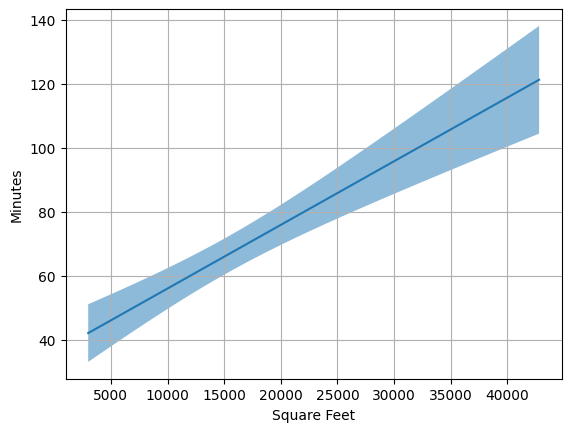

In [ ]:
axis = list(np.linspace(np.min(xs), np.max(xs), 100))
plt.plot(axis, Ey)
plt.fill_between(np.linspace(np.min(xs), np.max(xs), 100),
                 Ey + PL_linear_95_conf_width,
                 Ey - PL_linear_95_conf_width,
                 alpha = 0.5)
plt.grid()
plt.xlabel("Square Feet")
plt.ylabel("Minutes")

In [ ]:
axis = list(np.linspace(np.min(xs), np.max(xs), 100))
plt.plot(axis, Ey)
plt.fill_between(np.linspace(np.min(xs), np.max(xs), 100),
                 Ey + PL_joint_Linear_95_conf_width,
                 Ey - PL_joint_Linear_95_conf_width,
                 alpha = 0.5)
plt.grid()
plt.xlabel("Square Feet")
plt.ylabel("Minutes")

# Model 3 Plots

Text(0, 0.5, 'Minutes')

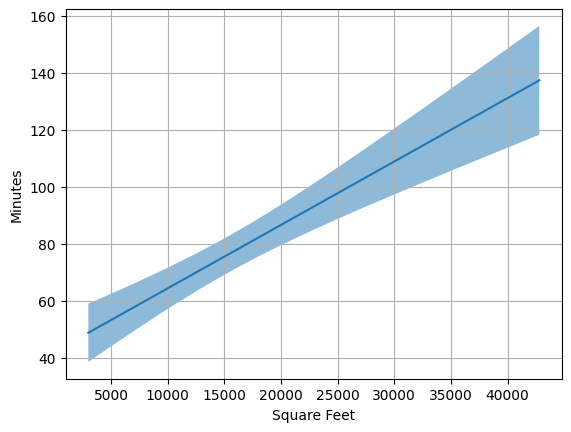

In [ ]:
axis = list(np.linspace(np.min(xs), np.max(xs), 100))
plt.plot(axis, q3y)
plt.fill_between(np.linspace(np.min(xs), np.max(xs), 100),
                 q3y + PL_linear_95_conf_width3,
                 q3y - PL_linear_95_conf_width3,
                 alpha = 0.5)
plt.grid()
plt.xlabel("Square Feet")
plt.ylabel("Minutes")

Text(0, 0.5, 'Minutes')

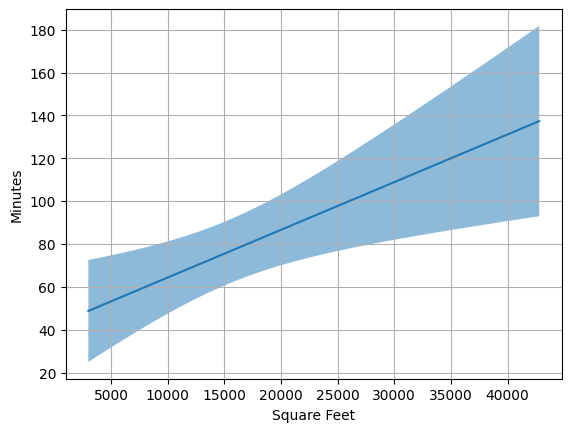

In [ ]:
axis = list(np.linspace(np.min(xs), np.max(xs), 100))
plt.plot(axis, q3y)
plt.fill_between(np.linspace(np.min(xs), np.max(xs), 100),
                 q3y + PL_joint_Linear_95_conf_width3,
                 q3y - PL_joint_Linear_95_conf_width3,
                 alpha = 0.5)
plt.grid()
plt.xlabel("Square Feet")
plt.ylabel("Minutes")

# q3 Weighted Plots

Text(0, 0.5, 'Minutes')

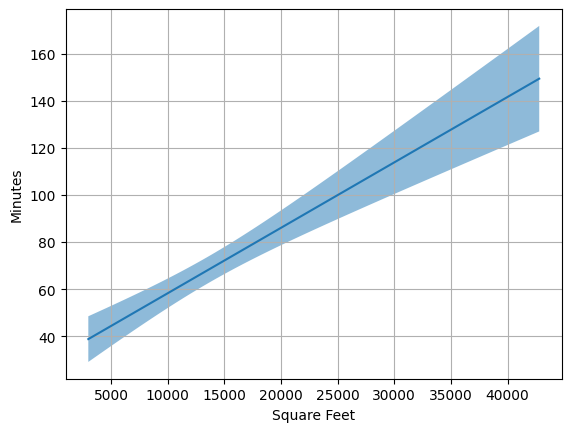

In [ ]:
axis = list(np.linspace(np.min(xs), np.max(xs), 100))
plt.plot(axis, q3wy)
plt.fill_between(np.linspace(np.min(xs), np.max(xs), 100),
                 q3wy + PLw_linear_95_conf_width,
                 q3wy - PLw_linear_95_conf_width,
                 alpha = 0.5)
plt.grid()
plt.xlabel("Square Feet")
plt.ylabel("Minutes")

# Model Validation

In [ ]:
#this is to simulate data with the full model and demonstrates how bad a linear
#model with the full data is
y = mow[:,0]
#y = np.log(mow[:,0])
x = mow[:,1]
xs = x

In [ ]:
#y = np.array(data_s["Mean"])
y = np.array(data_s["3rd Qu."])
x = np.array(data_s["Sq. Ft."])
xs = x


In [ ]:
#getting the fit depending on which model you'd like to simulate data with
p=2
q3_weights = np.identity(len(y))
#q3_weights = np.diag(1/np.array(q3_vars))
beta_p = polynomial_mle(xs, y, p, W=q3_weights )
X_s =  np.array([xs**i for i in range(p)]).T

In [ ]:
#simulated data params
mean = X_s@beta_p
linear_s_squared=  (y3 - X_s@beta5).T@q3_weights@(y3 - X_s@beta5)/(len(y3) - len(beta5))
#for the unweighted models
linear_s_squared2 = (np.linalg.norm(y - X_s@beta_p)**2) / (len(y) - len(beta_p))
var = np.diag(linear_s_squared*np.diagonal(X_s@LA.inv( X_s.T@q3_weights@X_s)@(X_s.T)))

In [ ]:
#simulated data
sim_data = np.random.multivariate_normal(mean, var, 1)

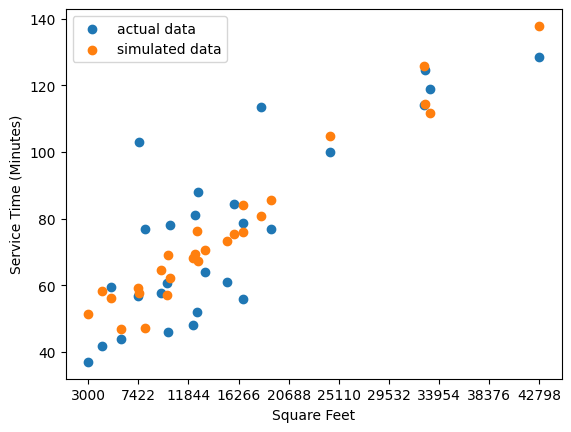

In [ ]:
#plots
plt.scatter(xs, y, label = "actual data")
plt.scatter(xs, sim_data, label = "simulated data")
plt.xticks(np.linspace(np.min(xs), np.max(xs), 10))
#plt.yticks(np.linspace(np.min(y), np.max(y), 10))
plt.xlabel("Square Feet")
plt.ylabel("Service Time (Minutes)")
plt.legend()